# INF367 project - Rule mining on extended KG using AMIE+

**Author**: Johanna Jøsang (fak006)

In [1]:
from pykeen.datasets import Wikidata5M
import pykeen
import tensorflow as tf
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
np.random.seed(0)
from signature_tools import subset_by_signature, subset_by_strict_signature, subset_by_frequency, most_frequent_objects, most_frequent_predicates, most_frequent_targets

from ampligraph.evaluation import train_test_split_no_unseen 
from ampligraph.latent_features import ComplEx
from ampligraph.latent_features import save_model
from ampligraph.evaluation import evaluate_performance
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import save_model, restore_model
from ampligraph.discovery import discover_facts

import matplotlib.pyplot as plt
import seaborn as sns


family_subset = np.loadtxt("family_subset.txt", dtype = 'object')
entities_subset = np.loadtxt("entities_subset.txt", dtype = 'object')
model = restore_model('./Wikidata_family_subset_100_epocs.pkl')
discoveries, discovery_ranks = discover_facts(family_subset, model, top_n = 5000, max_candidates = 50000, entities_subset = entities_subset, seed = 2)

['Q349243' 'child' 'Q333609']
<class 'numpy.ndarray'>
(3,)
A1: <class 'numpy.ndarray'>
Ad1: object
B: <class 'numpy.ndarray'>
Bd: object
A2: <class 'numpy.ndarray'>
A [[['Q349243' 'child' 'Q333609']]

 [['Q6761233' 'child' 'Q333609']]

 [['Q95992' 'child' 'Q333609']]

 [['Q5569757' 'child' 'Q333609']]

 [['Q704668' 'child' 'Q333609']]

 [['Q355710' 'child' 'Q333609']]

 [['Q3296283' 'child' 'Q333609']]

 [['Q26704631' 'child' 'Q333609']]

 [['Q18600482' 'child' 'Q333609']]

 [['Q5489855' 'child' 'Q333609']]]
B [['Q1000366' 'child' 'Q1701445']
 ['Q1000366' 'child' 'Q6776382']
 ['Q1000505' 'spouse' 'Q268177']
 ['Q1000505' 'spouse' 'Q540597']
 ['Q1000596' 'father' 'Q701504']
 ['Q1000596' 'sibling' 'Q718827']
 ['Q1000682' 'spouse' 'Q673856']
 ['Q10007' 'father' 'Q9994']
 ['Q10007' 'mother' 'Q5374627']
 ['Q10007' 'spouse' 'Q5374631']]
hallo False
hei [[[False  True False]
  [False  True False]
  [False False False]
  ...
  [False False False]
  [False False False]
  [False False False]]

 [

RuntimeError: :)

## Data preparation

In [3]:
# retrieve the data from Pykeen distribution
data_unprocessed = Wikidata5M()
data_unprocessed.summarize()

WARNING - You're trying to map triples with 156 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
WARNING - In total 156 from 5133 triples were filtered out
WARNING - You're trying to map triples with 180 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
WARNING - In total 180 from 5163 triples were filtered out
Wikidata5M (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    4594149     822           20614279
Testing     4594149     822               4977
Validation  4594149     822               4983
Total       -           -             20624239
Head    Relation    tail
------  ----------  --------
Q1      P1343       Q602358
Q1      P1419       Q1647152
Q1      P1552       Q11412
Q1      P2184       Q136407
Q1      P2670       Q18343



In [4]:
# extract all the data into a numpy array of triples
train_Wikidata = data_unprocessed.training.triples
test_Wikidata = data_unprocessed.testing.triples
validation_Wikidata = data_unprocessed.validation.triples
data_Wikidata = np.concatenate((train_Wikidata, test_Wikidata, validation_Wikidata))
data_Wikidata = data_Wikidata.astype('object') # used to have datatype '<U95' which was problematic for signature_tools functions

WARNING - Reconstructing all label-based triples. This is expensive and rarely needed.
WARNING - Reconstructing all label-based triples. This is expensive and rarely needed.
WARNING - Reconstructing all label-based triples. This is expensive and rarely needed.


## Family graph

Extracting rules from the entire Wikidata5M dataset is a bit too ambitious for this project, so instead rules will be extracted from a well-defined subset of Wikidata5M. This subset consists of all triples with relations that have to do with family structure.

In [10]:
# change predicate names to meaningful values
family_predicates_dict = {
    'P40': 'child', 
    'P22' : 'father', 
    'P25' : 'mother',
    'P26' : 'spouse', 
    'P1038' : 'relative', 
    'P3373' : 'sibling', 
    #'P1290' : 'godparent'
    #'P451' : 'unmarried_partner'
    'P3448' : 'stepparent'
}
family_pred_ids = list(family_predicates_dict.keys())
family_relations = list(family_predicates_dict.values())

family_subset = subset_by_signature(data_Wikidata, [], family_pred_ids, [])
family_subset[:,1] = np.array([family_predicates_dict[p] for p in family_subset[:,1]])

print("The type of predicates that are used in this subset are:", family_relations)

The type of predicates that are used in this subset are: ['child', 'father', 'mother', 'spouse', 'relative', 'sibling', 'stepparent']


In [2]:
'''UNCOMMENT TO REPLACE FAMILY SUBSET'''
#pd.DataFrame(family_subset).to_csv("family_subset.txt", sep = "\t", header=None, index=None)
family_subset = np.loadtxt("family_subset.txt", dtype = 'object')

## Rule mining on entire family graph
Use AMIE+ to mine rules. Call jar file from https://github.com/lajus/amie using this command:

>java -jar amie-dev.jar -bias lazy -full -noHeuristics -ostd [TSV file] > [txt file to save rules in]

In [5]:
'''UNCOMMENT TO SAVE NEW SUBSET'''
#pd.DataFrame(family_subset).to_csv("family_KB.txt", sep = "\t", header=None, index=None) # remember to later rename to tsv filetype

'UNCOMMENT TO SAVE NEW SUBSET'

### Manual work:

1. rename "family_KB.txt" to "family_KB.csv"
2. Mine rules with command:
```java -jar amie-milestone-intKB.jar -bias lazy -full -noHeuristics -ostd family_KB.tsv > family_mined_rules.txt```
3. Remove useless text so that family_mined_rules.txt only contains the mined rules. Save as family_mined_rules_cleaned.txt

In [6]:
family_mining_results = pd.read_csv("family_mined_rules_cleaned.txt", sep="\t", names=["Rule", "Head_Coverage_A", "PCA_Confidence_A", "Positive_Examples_A", "PCA_Body_size_A", "Functional_variable"], skiprows = 1)

In [7]:
family_mining_results

,Rule,Head_Coverage_A,PCA_Confidence_A,Positive_Examples_A,PCA_Body_size_A,Functional_variable
0,?b relative ?a => ?a stepparent ?b,0.056604,0.750000,6,8,-1
1,?b relative ?a => ?a relative ?b,0.551117,0.846306,2566,3032,-2
2,?b spouse ?a => ?a spouse ?b,0.947832,0.992355,44132,44472,-1
3,?b sibling ?a => ?a sibling ?b,0.961588,0.989634,72748,73510,-2
4,?b relative ?h ?a sibling ?h => ?a stepparent ?b,0.018868,0.500000,2,4,-1
...,...,...,...,...,...,...
59,?a father ?h ?b father ?h => ?a sibling ?b,0.773231,0.658865,58498,88786,-2
60,?h sibling ?a ?b sibling ?h => ?a sibling ?b,0.716023,0.584857,54170,92621,-2
61,?h sibling ?b ?a sibling ?h => ?a sibling ?b,0.721059,0.588151,54551,92750,-2
62,?a sibling ?h ?b sibling ?h => ?a sibling ?b,0.718680,0.590059,54371,92145,-2


## Rule mining on subset of graph

We now do the same procedure as above with a subset of the graph. This subset will contain 90% of the original data in the family graph, and the datapoints to be included will be selected at random.

In [8]:
# Extract subset contaning 90% of the data
random_subset_mask = np.random.choice([False, True], len(family_subset), p=[0.1, 0.9])
family_subset_subset = family_subset[random_subset_mask]

In [9]:
'''UNCOMMENT TO SAVE NEW SUBSET'''
#pd.DataFrame(family_subset_subset).to_csv("family_random_subset_KB.txt", sep = "\t", header=None, index=None)

'UNCOMMENT TO SAVE NEW SUBSET'

### Manual work:

1. Rename "family_random_subset_KB.txt" to "family_random_subset_KB.csv"
2. Mine rules with command: ```java -jar amie-milestone-intKB.jar -bias lazy -full -noHeuristics -ostd family_random_subset_KB.tsv > family_random_subset_mined_rules.txt```
3. Remove useless text so that family_random_subset_mined_rules.txt only contains the mined rules. Save as family_random_subset_mined_rules_cleaned.txt

In [10]:
family_random_subset_mining_results = pd.read_csv("family_random_subset_mined_rules_cleaned.txt", sep="\t", names=["Rule", "Head_Coverage_B", "PCA_Confidence_B", "Positive_Examples_B", "PCA_Body_size_B", "Functional_variable"], skiprows = 1)

In [11]:
family_random_subset_mining_results

,Rule,Head_Coverage_B,PCA_Confidence_B,Positive_Examples_B,PCA_Body_size_B,Functional_variable
0,?b relative ?a => ?a relative ?b,0.489102,0.799217,2042,2555,-2
1,?b spouse ?a => ?a spouse ?b,0.851667,0.974573,35684,36615,-1
2,?b sibling ?a => ?a sibling ?b,0.866911,0.917226,59184,64525,-2
3,?h relative ?a ?b sibling ?h => ?a relative ?b,0.079760,0.314745,333,1058,-2
4,?b mother ?h ?h relative ?a => ?a relative ?b,0.015808,0.208202,66,317,-2
5,?a relative ?h ?b sibling ?h => ?a relative ?b,0.117365,0.454968,490,1077,-2
6,?b mother ?h ?a relative ?h => ?a relative ?b,0.022754,0.293210,95,324,-2
7,?b relative ?h ?a sibling ?h => ?a relative ?b,0.075449,0.110217,315,2858,-2
8,?h father ?a ?b father ?h => ?a relative ?b,0.018922,0.187204,79,422,-2
9,?h relative ?b ?a sibling ?h => ?a relative ?b,0.098683,0.116089,412,3549,-2


## Rule comparison
This section examines which rules were mined from the entire family graph and compare them with the rules mined from the subset of that graph.

First the overlap of the rules mined will calculated, and then the difference in scores calculated for the commonly mined rules is examined.

In [12]:
# Group rules to see which are common or unique to the two mined sets
common_rules = pd.merge(family_mining_results, family_random_subset_mining_results, how='inner', on=['Rule', "Functional_variable"])
uncommon_rules = pd.concat([family_mining_results, family_random_subset_mining_results]).drop_duplicates(["Rule"], keep=False)
all_rules = pd.merge(family_mining_results, family_random_subset_mining_results, how='outer', on=['Rule'])
unique_incomplete_graph = family_random_subset_mining_results[~family_random_subset_mining_results.Rule.isin(family_mining_results.Rule)]
unique_complete_graph = family_mining_results[~family_mining_results.Rule.isin(family_random_subset_mining_results.Rule)]

In [13]:
all_rules_count = len(all_rules)
common_rules_count = len(common_rules)
subset_graph_rule_count = len(family_random_subset_mining_results)
complete_graph_rule_count = len(family_mining_results)

In [14]:
unique_subset_count = len(unique_incomplete_graph)
unique_complete_count = len(unique_complete_graph)
common_count = len(common_rules)

In [15]:
print("Rules unique to incomplete graph")
unique_incomplete_graph

Rules unique to incomplete graph


,Rule,Head_Coverage_B,PCA_Confidence_B,Positive_Examples_B,PCA_Body_size_B,Functional_variable
22,?h mother ?b ?a relative ?h => ?a relative ?b,0.020120,0.270096,84,311,-2
25,?g father ?b ?a relative ?g => ?a relative ?b,0.053413,0.352848,223,632,-2
32,?a father ?g ?g spouse ?b => ?a mother ?b,0.620180,0.705733,9183,13012,-1


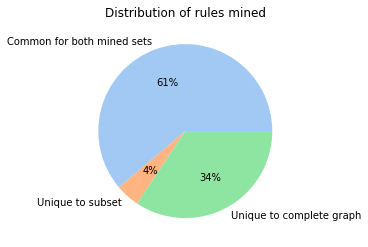

In [16]:
# plot distribution of the mined rules
data = [common_count, unique_subset_count, unique_complete_count]
labels = ['Common for both mined sets', 'Unique to subset', 'Unique to complete graph']

#define Seaborn color pallette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Distribution of rules mined")
plt.show()

## Difference in head coverage and PCA confidence 
Compare the head coverage and PCA confidence of rules when calculated on the complete graph and the subset of the graph.
This is only done on the rules that were commonly mined from both graphs.

In [17]:
common_rules["HC_Diff"] = common_rules["Head_Coverage_B"] - common_rules["Head_Coverage_A"]
common_rules["PCA_Conf_Diff"] = common_rules["PCA_Confidence_B"] - common_rules["PCA_Confidence_A"]
common_rules["Pos_Ex_Diff"] = common_rules["Positive_Examples_B"] - common_rules["Positive_Examples_A"]
common_rules["PCA_Body_Size_Diff"] = common_rules["PCA_Body_size_B"] - common_rules["PCA_Body_size_A"]

In [18]:
rule_diffs = common_rules[["Rule", "HC_Diff", "PCA_Conf_Diff"]]

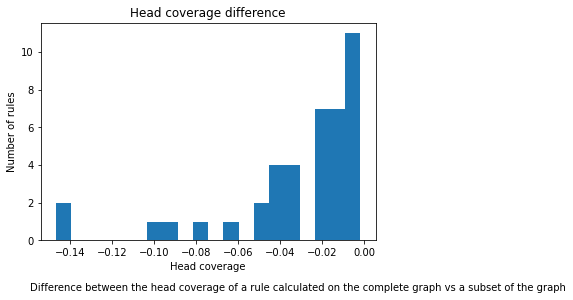

In [19]:
plt.hist(rule_diffs["HC_Diff"], bins = 20)
plt.title("Head coverage difference")
plt.figtext(.1, -0.05, "Difference between the head coverage of a rule calculated on the complete graph vs a subset of the graph")
plt.xlabel("Head coverage")    
plt.ylabel("Number of rules")    
plt.show()

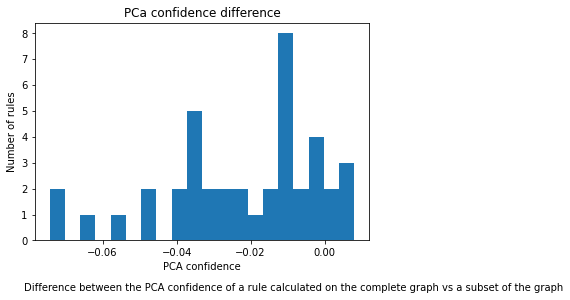

In [20]:
plt.hist(rule_diffs["PCA_Conf_Diff"], bins = 20)
plt.title("PCa confidence difference")
plt.figtext(.1, -0.05, "Difference between the PCA confidence of a rule calculated on the complete graph vs a subset of the graph")
plt.xlabel("PCA confidence")    
plt.ylabel("Number of rules")    
plt.show()

---
# KG embedding using Ampligraph

**THIS SECTION CONTAINS CODE THAT WOULD HAVE BEEN USED IF NOT FOR ISSUES WITH THE APLIGRAPH LIBRARY**

AmpliGraph has implemented [several Knoweldge Graph Embedding models](https://docs.ampligraph.org/en/latest/ampligraph.latent_features.html#knowledge-graph-embedding-models) (TransE, ComplEx, DistMult, HolE), but for this project we will only use the [ComplEx](https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.ComplEx.html#ampligraph.latent_features.ComplEx) model (with  default values).

In [14]:
X_train, X_test = train_test_split_no_unseen(family_subset, test_size=100, seed = 0) 

'''UNCOMMENT TO SAVE NEW TRAIN AND TEST SET'''
#pd.DataFrame(X_train).to_csv("X_train.txt", sep = "\t", header=None, index=None)
#pd.DataFrame(X_test).to_csv("X_test.txt", sep = "\t", header=None, index=None)

In [3]:
X_train = np.loadtxt("X_train.txt", dtype = 'object')
X_test = np.loadtxt("X_test.txt", dtype = 'object')

In [16]:
# generate set of entities to generate counterexamples from
top_targets = most_frequent_targets(X_train, n=10000)[:,1]
top_objects = most_frequent_objects(X_train, n=10000)[:,1]
entities_subset = np.concatenate([top_targets, top_objects[~np.isin(top_objects,top_targets)]])

In [18]:
'''UNCOMMENT TO SAVE entities subset'''
#pd.DataFrame(entities_subset).to_csv("entities_subset.txt", sep = "\t", header=None, index=None)

'UNCOMMENT TO SAVE entities subset'

In [3]:
entities_subset = np.loadtxt("entities_subset.txt", dtype = 'object')

In [6]:
# initialize model
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=100, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

## Fitting the model

In [7]:
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train, early_stopping = False)

Average ComplEx Loss:   0.000690: 100%|█| 100/100 [2:16:44<00:00, 82.05s/epoch]


In [8]:
save_model(model, './Wikidata_family_subset_100_epocs.pkl')

Uncomment to save new model

In [4]:
model = restore_model('./Wikidata_family_subset_100_epocs.pkl')

## Evaluate model

In [10]:
positives_filter = family_subset
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.
WARNING - You are attempting to use 116236 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.


c:\users\johan\appdata\local\programs\python\python37\lib\site-packages\ampligraph\evaluation\protocol.py:952: UserWarning: You are attempting to use 116236 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.
  warnings.warn(warn_msg % ent_for_corruption_size)
100%|████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


In [11]:
mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.95
Hits@10: 0.99
Hits@3: 0.98
Hits@1: 0.92


## Generate new triples

This is where the error is enountered :(

In [5]:
discoveries, discovery_ranks = discover_facts(family_subset, model, top_n = 5000, max_candidates = 50000, entities_subset = entities_subset, seed = 2)

A1: <class 'numpy.ndarray'>
Ad1: object
B: <class 'numpy.ndarray'>
Bd: object
A2: <class 'numpy.ndarray'>
A [[['Q349243' 'child' 'Q333609']]

 [['Q6761233' 'child' 'Q333609']]

 [['Q95992' 'child' 'Q333609']]

 [['Q5569757' 'child' 'Q333609']]

 [['Q704668' 'child' 'Q333609']]

 [['Q355710' 'child' 'Q333609']]

 [['Q3296283' 'child' 'Q333609']]

 [['Q26704631' 'child' 'Q333609']]

 [['Q18600482' 'child' 'Q333609']]

 [['Q5489855' 'child' 'Q333609']]]
B [['Q1000366' 'child' 'Q1701445']
 ['Q1000366' 'child' 'Q6776382']
 ['Q1000505' 'spouse' 'Q268177']
 ['Q1000505' 'spouse' 'Q540597']
 ['Q1000596' 'father' 'Q701504']
 ['Q1000596' 'sibling' 'Q718827']
 ['Q1000682' 'spouse' 'Q673856']
 ['Q10007' 'father' 'Q9994']
 ['Q10007' 'mother' 'Q5374627']
 ['Q10007' 'spouse' 'Q5374631']]


RuntimeError: :)

In [56]:
a = np.array([['Q828550', 'child', 'Q2426845']], dtype=object)
b = np.array([['Q1774982', 'father', 'Q215546']], dtype=object)
c = np.array([['Q6845092', 'mother', 'Q16840232']], dtype=object)
d = np.array([['Q5649896', 'relative', 'Q2426845']], dtype=object)
e = np.array([['Q65428', 'sibling', 'Q110374'],['Q380341', 'sibling', 'Q313219'],['Q24082781', 'sibling', 'Q5543457']], dtype=object)
f = np.array([], dtype=object)
g = np.array([], dtype=object)

In [57]:
disc = [a,b,c,d,e,f,g]

In [72]:
disc = [a.tolist(),b.tolist(),c.tolist(),d.tolist(),e.tolist(),f.tolist(),g.tolist()]

In [74]:
flat_list = [item for sublist in disc for item in sublist]

In [75]:
flat_list

[['Q828550', 'child', 'Q2426845'],
 ['Q1774982', 'father', 'Q215546'],
 ['Q6845092', 'mother', 'Q16840232'],
 ['Q5649896', 'relative', 'Q2426845'],
 ['Q65428', 'sibling', 'Q110374'],
 ['Q380341', 'sibling', 'Q313219'],
 ['Q24082781', 'sibling', 'Q5543457']]

In [13]:
family_subset

array([['Q1000366', 'child', 'Q1701445'],
       ['Q1000366', 'child', 'Q6776382'],
       ['Q1000505', 'spouse', 'Q268177'],
       ...,
       ['Q913574', 'spouse', 'Q235629'],
       ['Q953878', 'relative', 'Q314514'],
       ['Q9749', 'sibling', 'Q706559']], dtype=object)

In [14]:
family_subset.shape

(258341, 3)